# Lab

### Configuration

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects: list[LinesCollection] = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [15]:
class Scene:
    def __init__(self, points = None, lines = None):
        self.points = points or []
        self.lines = lines or []

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = None, points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes or [Scene()]
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

    @staticmethod
    def save_to_file(self, file_name: str):
        plt.savefig(file_name + '.png' if file_name.find('.') == -1 else file_name)
        

### Rozwiązanie

In [16]:
from typing import Callable
from enum import Enum
import functools

#config
epsilon = np.float64(1e-8)

point_type = tuple[np.float64, np.float64]
rectangle_type = tuple[point_type, point_type]
vector_type = tuple[point_type, point_type]
matrix_type = list[list[np.float64]]


class ChainClassification(Enum):
    LEFT = -1
    RIGHT = 1

class PointRelativePosition(Enum):
    LEFT = 1
    COLLINEAR = 2
    RIGHT = 3

class PointsOrientation(Enum):
    CCW = 1
    COLL = 0
    CW = -1

class PointType(Enum):
    STARTING = 1
    ENDING = 2
    CONNECTING = 3
    DIVIDING = 4
    CORRECT = 5

class Vector2d:
    def __init__(self, x: np.float64, y: np.float64):
        self.x = x
        self.y = y

        self._cmp_function = lambda p1, p2: p1.x == p2.x and p1.y == p2.y

    @staticmethod
    def from_tuple(tuple_point: point_type):
        return Vector2d(*tuple_point)

    def set_cmp_function(self, cmp_function: Callable):
        self._cmp_function = cmp_function

    def to_tuple(self) -> point_type:
        return self.x, self.y


    def __lt__(self, other):
        return self._cmp_function(self, other) < 0

    def __eq__(self, other):
        return self._cmp_function(self, other) == 0

    def __gt__(self, other):
        return self._cmp_function(self, other) > 0

    def __add__(self, other):
        return Vector2d(self.x + other.x, self.y + other.y)

    def __str__(self):
        return f'Vector(x={self.x}, y={self.y})'

    def __repr__(self):
        return str(self)

    def __getitem__(self, item):
        if item == 0:
            return self.x
        if item == 1:
            return self.y


class BoundVector:
    def __init__(self, a: Vector2d, b: Vector2d):
        self.a = a
        self.b = b


class PointClassifier:
    def __init__(self, collinear_tolerance: np.float64, point_det_function: Callable[[Vector2d, Vector2d, Vector2d], np.float64]):
        self.calc_det = point_det_function

        self.collinear_tolerance = collinear_tolerance

    def classify_rel_to_vector(self, point: Vector2d, vector: BoundVector):
        det = self.calc_det(vector.a, vector.b, point)

        if abs(det) < self.collinear_tolerance:
            return PointRelativePosition.COLLINEAR
        if det > 0:
            return PointRelativePosition.LEFT
        if det < 0:
            return PointRelativePosition.RIGHT

    def orientation(self, a: Vector2d, b: Vector2d, c: Vector2d):
        det = self.calc_det(a, b, c)

        if abs(det) < self.collinear_tolerance:
            return PointsOrientation.COLL
        if det > 0:
            return PointsOrientation.CCW
        if det < 0:
            return PointsOrientation.CW


    def classify_point_b(self, a: Vector2d, b: Vector2d, c: Vector2d) -> PointType:
        """
        Determines if point B is STARTING, ENDING, DIVIDING, CONNECTING or CORRECT.
        Points must be given in the same order that they are in the figure (counterclockwise)
        :param a: point
        :param b: point
        :param c: point
        :return: One of STARTING, ENDING, DIVIDING, CONNECTING, CORRECT
        """
        orientation = self.orientation(a, b, c)

        if orientation == PointsOrientation.CCW and c.y < b.y and a.y < b.y:
            return PointType.STARTING
        if orientation == PointsOrientation.CCW and a.y > b.y and c.y > b.y:
            return PointType.ENDING
        if orientation == PointsOrientation.CW and a.y < b.y and c.y < b.y:
            return PointType.DIVIDING
        if orientation == PointsOrientation.CW and a.y > b.y and c.y > b.y:
            return PointType.CONNECTING

        return PointType.CORRECT


class PointsComparator:
    def __init__(self, a: Vector2d, point_classifier: PointClassifier):
        self.a = a
        self.point_classifier = point_classifier

    def compare_angles(self, b: Vector2d, c: Vector2d) -> int:
        c_rel_pos = self.point_classifier.classify_rel_to_vector(c, BoundVector(self.a, b))

        if c_rel_pos == PointRelativePosition.LEFT:
            return -1 # c is 'smaller' than b
        if c_rel_pos == PointRelativePosition.COLLINEAR:
            return 0
        if c_rel_pos == PointRelativePosition.RIGHT:
            return 1 # c is 'greater' than b

    def compare_distance(self, b: Vector2d, c: Vector2d):
        db = dist(self.a.to_tuple(), b.to_tuple())
        dc = dist(self.a.to_tuple(), c.to_tuple())

        return np.sign(dc - db)


def create_2x2_matrix(a: Vector2d, b: Vector2d, c: Vector2d):
    return [
        [a.x - c.x, a.y - c.y],
        [b.x - c.x, b.y - c.y]
    ]



def calc_det(matrix):  # calculation of matrix det written for WDI
    def calc_det_recur(_matrix, y, il, poss, perm, inv):
        if y >= len(matrix):
            nonlocal su

            if inv % 2 == 0:
                sign = 1
            else:
                sign = -1

            su += sign * il
            return il

        for curr_i in poss:
            inv_c = inv
            for perm_el in perm:
                if perm_el > curr_i:
                    inv_c += 1

            calc_det_recur(_matrix, y + 1, il * _matrix[y][curr_i], [i for i in poss if i != curr_i], perm + [curr_i],
                           inv_c)

    su = 0
    poss = [i for i in range(len(matrix))]
    for curr_i in range(len(matrix[0])):
        calc_det_recur(matrix, 1, matrix[0][curr_i], [i for i in poss if i != curr_i], [curr_i], 0)

    return su


def parse_figure_lines_to_points(lines_collection: LinesCollection) -> list[Vector2d]:
    points = [Vector2d.from_tuple(p1) for p1, p2 in lines_collection.lines]
    if len(lines_collection.lines) > 0:
        points.append(Vector2d.from_tuple(lines_collection.lines[-1][1]))

    return points

def divide_points_into_groups(classifications: list[PointType]) -> dict[PointType, list[int]]:
    groups = {
        PointType.STARTING: list(),
        PointType.ENDING: list(),
        PointType.CONNECTING: list(),
        PointType.DIVIDING: list(),
        PointType.CORRECT: list()
    }

    for i, classification in enumerate(classifications):
        groups[classification].append(i)

    return groups


def classify_points(points: list[Vector2d], point_classifier: PointClassifier) -> list[PointType]:
    classifications = [PointType.CORRECT] * len(points)

    for i in range(-1, len(points)-1):
        classifications[i] = point_classifier.classify_point_b(points[i-1], points[i], points[i+1]) # works because of python negative indexes

    return classifications


def get_tuple_points_in_collections(points: list[Vector2d], points_classifications: list[PointType]):
    points_collections = {
        PointType.STARTING: PointsCollection(points=[], color='green'),
        PointType.ENDING: PointsCollection(points=[], color='red'),
        PointType.CONNECTING: PointsCollection(points=[], color='purple'),
        PointType.DIVIDING: PointsCollection(points=[], color='darkturquoise'),
        PointType.CORRECT: PointsCollection(points=[], color='saddlebrown'),
    }
    for i in range(len(points)):
        points_collections[points_classifications[i]].points.append(points[i].to_tuple())

    return list(points_collections.values())

    # return Scene(points=points_collections.items())


def find_index_of_the_most_extreme_point(points: list[Vector2d], which = 1):
    extreme_i = 0
    for i in range(1, len(points)):
        if which*points[i].y > which*points[extreme_i].y:
            extreme_i = i

    return extreme_i


def get_and_visualize_points(input_plot: Plot, point_classifier: PointClassifier):
    scenes = []
    for figure in input_plot.get_added_figure():
        figure_copy = LinesCollection(lines=figure.lines.copy())
        points = parse_figure_lines_to_points(figure)

        points_classifications = classify_points(points, point_classifier)

        points_collections = get_tuple_points_in_collections(points, points_classifications)

        figure_copy.lines.append((figure.lines[-1][1], figure.lines[0][0]))
        scenes.append(Scene(points=points_collections, lines=[figure_copy]))

    return Plot(scenes=scenes)


def is_y_monotonic(points: list[Vector2d]):
    mini_i = find_index_of_the_most_extreme_point(points, -1)

    visited = [False]*len(points)
    visited[mini_i] = True
    i = (mini_i + 1) % len(points)
    while points[i-1].y < points[i].y:
        visited[i] = True
        i = (i+1)%len(points)

    i = (mini_i - 1) % len(points)
    while points[(i+1)%len(points)].y < points[i].y:
        visited[i] = True
        i -= 1

    return all(visited)


def get_figure_and_check_if_it_is_y_monotonic(input_plot: Plot):
    monotonic = []
    for figure in input_plot.get_added_figure():
        points = parse_figure_lines_to_points(figure)
        monotonic.append(is_y_monotonic(points))

    return monotonic


def create_scene(figure: LinesCollection, all_points: list[Vector2d], diagonals: list, stack: list[Vector2d], current_point: Vector2d = None):
    all_points_coll = PointsCollection(points=list(map(Vector2d.to_tuple, all_points)), color='gray')
    diagonals_coll = LinesCollection(lines=diagonals.copy(), color='black')
    stack_coll = PointsCollection(points=stack.copy(), color='red')
    current_point_coll = PointsCollection(points=[current_point.to_tuple()] if current_point is not None else [], color='indigo', s=100)

    return Scene(lines=[figure, diagonals_coll], points=[all_points_coll, stack_coll, current_point_coll])


def triangulate(figure: LinesCollection, point_classifier: PointClassifier, visualize = False):
    figure_copy = LinesCollection(lines=figure.lines.copy())
    figure_copy.lines.append((figure.lines[-1][1], figure.lines[0][0]))
    points = parse_figure_lines_to_points(figure)
    if not is_y_monotonic(points):
        return None, None

    sorted_points_i = sorted(list(range(len(points))), key=lambda p_i: points[p_i].y, reverse=True)
    mini_i = sorted_points_i[0]
    maxi_i = sorted_points_i[-1]

    chains = [ChainClassification.LEFT]*len(points)
    for i in range(maxi_i, (mini_i if mini_i > maxi_i else mini_i + len(points)) + 1):
        i = i % len(points)
        chains[i] = ChainClassification.RIGHT

    diagonals = []

    scenes = []

    tuple_stack = [points[sorted_points_i[0]].to_tuple(), points[sorted_points_i[1]].to_tuple()]
    stack = sorted_points_i[:2]
    if visualize:
        scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack))
    for point_i in sorted_points_i[2:-1]:
        if visualize:
            scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[point_i]))

        if chains[point_i] == chains[stack[-1]]:
            while len(stack) >= 2 and point_classifier.orientation(points[stack[-2]], points[stack[-1]], points[point_i]).value * chains[point_i].value < 0:
                if visualize:
                    scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[point_i]))
                    last_points = list(map(Vector2d.to_tuple, [points[stack[-2]], points[stack[-1]], points[point_i]]))
                    scenes[-1].points.append(PointsCollection(points=last_points, color='blue'))

                diagonals.append((points[stack[-2]].to_tuple(), points[point_i].to_tuple()))
                stack.pop()

                if visualize:
                    tuple_stack.pop()
                    scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[point_i]))

            if visualize and len(stack) >= 2:
                scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[point_i]))
                last_points = list(map(Vector2d.to_tuple, [points[stack[-2]], points[stack[-1]], points[point_i]]))
                scenes[-1].points.append(PointsCollection(points=last_points, color='blue'))

        else:
            stack_top = stack[-1]
            while len(stack) > 0:
                stack_point_i = stack.pop()
                diagonals.append((points[stack_point_i].to_tuple(), points[point_i].to_tuple()))

                if visualize:
                    tuple_stack.pop()
                    scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[point_i]))

            stack.append(stack_top)

            if visualize:
                tuple_stack.append(points[stack_top].to_tuple())

        stack.append(point_i)
        if visualize:
            tuple_stack.append(points[point_i].to_tuple())
            scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[point_i]))


    if visualize:
        scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[sorted_points_i[-1]]))

    while len(stack) > 0:
        stack_point_i = stack.pop()
        if abs(sorted_points_i[-1] - stack_point_i) <= 1 or abs(sorted_points_i[-1] - stack_point_i) >= len(points) - 1:
            continue
        diagonals.append((points[stack_point_i].to_tuple(), points[sorted_points_i[-1]].to_tuple()))

        if visualize:
            tuple_stack.pop()
            scenes.append(create_scene(figure_copy, points, diagonals, tuple_stack, points[sorted_points_i[-1]]))

    return diagonals, Plot(scenes=scenes)


def get_figure_and_triangulate(input_plot: Plot, point_classifier: PointClassifier, visualize = False):
    if len(input_plot.get_added_figure()) == 0:
        return Plot()

    figure = input_plot.get_added_figure()[-1] # use the last added figure

    diagonals, plot = triangulate(figure, point_classifier, visualize)
    if diagonals is None:
        print("nie monotoniczny")
        return Plot()
    print(diagonals)
    print("ilość dodanych przekątnych", len(diagonals))

    return plot


In [4]:
det_calculation = lambda a, b, c: calc_det(create_2x2_matrix(a, b, c))
pt_classifier = PointClassifier(epsilon, det_calculation)


Input plot

<IPython.core.display.Javascript object>


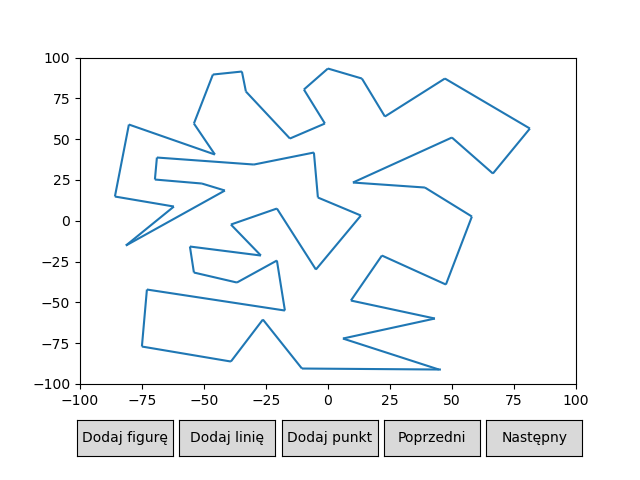

(-100.0, 100.0)

In [28]:
%matplotlib notebook

inp_plot = Plot()
inp_plot.draw()
ax = plt.gca()
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))


In [29]:
# Check if the figure is y-monotonic
get_figure_and_check_if_it_is_y_monotonic(inp_plot)


[False]

<IPython.core.display.Javascript object>


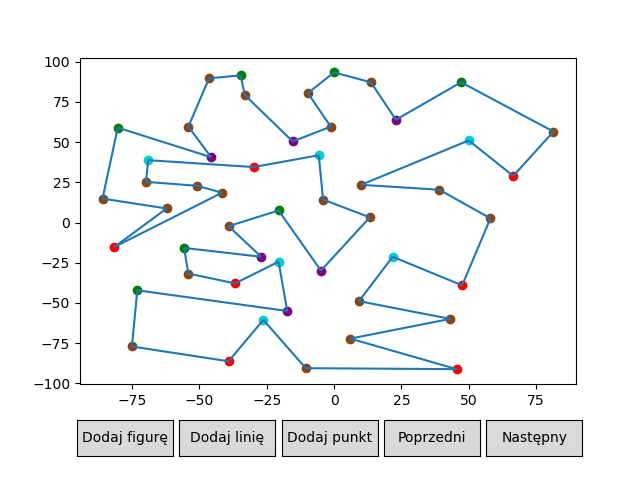

In [30]:
# visualize point types
%matplotlib notebook
points_types_visualization_plot = get_and_visualize_points(inp_plot, pt_classifier)
points_types_visualization_plot.draw()


nie monotoniczny


<IPython.core.display.Javascript object>


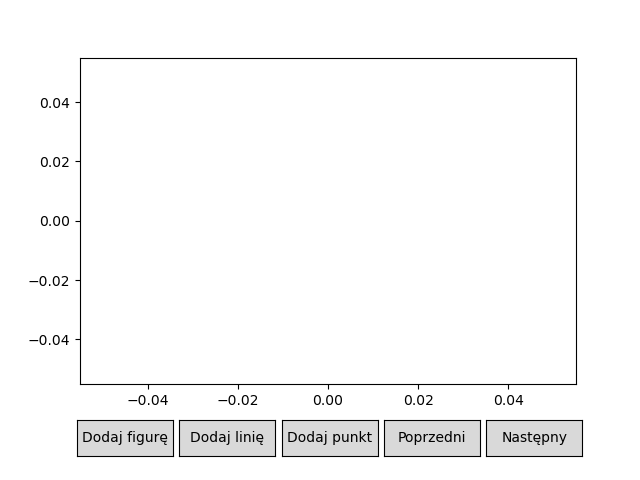

In [31]:
%matplotlib notebook
triangulation_vis = get_figure_and_triangulate(inp_plot, pt_classifier, visualize=True)
triangulation_vis.draw()
